In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = '/kaggle/input/image-dataset/lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA available")
else:
    print("CUDA not available")
    device = torch.device("cpu")

CUDA available


torch.Size([250, 250, 3])


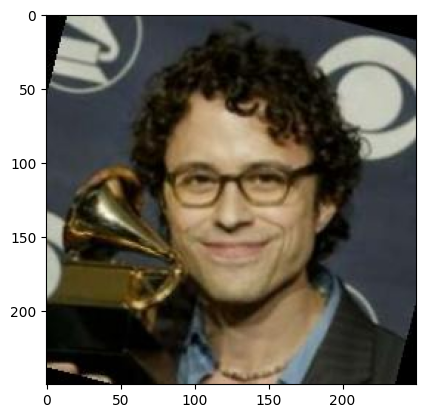

In [5]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

The premise of this project involves modifying your AutoEncoder implementation from the previous assignment to incorporate the essential components of a Variational AutoEncoder (VAE). It's important to explicitly outline the distinctions between AutoEncoders and VAEs in terms of Applications, Architecture, and Loss function.

Autoencoders (AEs) and Variational Autoencoders (VAEs) share a common foundation, with VAEs being a specific subtype of autoencoder that integrates probabilistic elements. Here are the primary differences between Autoencoders and Variational Autoencoders:

1. Applications:
Autoencoders (AEs):

AEs are predominantly utilized for unsupervised learning tasks like data compression, denoising, and feature learning.
They excel in representation learning, acquiring a concise and meaningful representation of input data.
Variational Autoencoders (VAEs):

VAEs extend the capabilities of AEs and are especially adept at generating new samples through sampling from the learned latent space.
Commonly employed in generative modeling tasks, including image synthesis, style transfer, and data generation.

2. Architecture:
Autoencoders (AEs):

Composed of an encoder and a decoder.
The encoder maps input data to a lower-dimensional latent space representation.
The decoder reconstructs input data from this compressed representation.
Often features a bottleneck layer where the representation is condensed.
Variational Autoencoders (VAEs):

Also comprises an encoder and a decoder, introducing a probabilistic approach to the latent space.
Instead of producing a deterministic representation, the encoder outputs mean and variance parameters of a probability distribution (usually Gaussian) in the latent space.
Incorporates a stochastic element, facilitating the generation of diverse samples.

3. Loss Function:
Autoencoders (AEs):

Typically employ a reconstruction loss, such as Mean Squared Error (MSE), measuring the disparity between input and reconstructed output.
Goal is to minimize the reconstruction loss for faithful reconstruction.
Variational Autoencoders (VAEs):

Utilize a combination of two terms in their loss function: a reconstruction loss and a regularization term (KL divergence).
The reconstruction loss gauges the fidelity of the reconstructed output.
The KL divergence term encourages the learned latent space to adhere to a specific probabilistic distribution, often a unit Gaussian, thereby regularizing the latent space.

In summary, while both AEs and VAEs strive to learn efficient representations of input data, VAEs introduce probabilistic elements to the latent space. This enables more sophisticated generation tasks and provides a framework for sampling new data points, making VAEs particularly potent in scenarios where generating diverse samples is a crucial requirement.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dims=20):  # Adjust latent_dims to get the desired output shape
        super(VAE, self).__init__()
        self.mu = nn.Linear(64 * 32 * 32, latent_dims)
        self.logvar = nn.Linear(64 * 32 * 32, latent_dims)
        self.encoded_image = self.encoder();
        self.decoder_input = nn.Linear(latent_dims, 64 * 32 * 32)
        self.decoded_image = self.decoder()
        
    def encoder(self) : 
        return nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU())

    def decoder(self):
        return nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=1, padding=0),  
            nn.Sigmoid())
            
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        
        # Pass the input through the encoder
        encode_image = self.encoded_image(x)
        encode_image = encode_image.view(encode_image.size(0), -1)
        
        # Compute the mean and log variance vectors
        mu, logvar = self.mu(encode_image), self.logvar(encode_image)
        
        # Reparameterize the latent variable
        q = self.reparameterize(mu, logvar)
        
        # Pass the latent variable through the decoder
        decode_image = self.decoder_input(z)
        decode_image = decode_image.view(decode_image.size(0), 64, 32, 32) 
        return self.decoded_image(decode_image), mu, logvar

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In a Variational AutoEncoder (VAE), the latent space is characterized as a Gaussian distribution with a mean (μ) and a log variance (log_var). To create new samples within the latent space, the reparameterization trick is applied. This involves sampling from a standard normal distribution (eps = torch.randn_like(std)), and then adjusting the sampled values using the mean and standard deviation derived from the encoder.

Here's a breakdown of the steps to generate new samples in the latent space of a VAE:

1. Encode an Input Image: Pass an input image through the encoder to acquire the mean (μ) and log variance (log (σ^2)) vectors.
2. Reparameterization Trick: Utilize the formula z = μ + ϵ⋅σ, where ϵ represents a sample from a standard normal distribution.
3. Generate New Samples: The resulting z vector represents a point within the latent space.
4. Decode to Generate Images: Feed the generated z vectors through the decoder to obtain corresponding images. This step completes the process by transforming the latent space representation into visually interpretable output.

In [7]:
# Instantiate the VAE model
model = VAE().to(device)

# Load 1 batch of images
image, _ = next(iter(dataloader))
image = image.to(device)

encoded_output = model.encoded_image(image)
print("Shape of encoded image : ", encoded_output.shape)

# Forward pass
decoded, mu, logvar = model(image)

# Obtaining latent Space samples using Reparameterization
std = torch.exp(0.5 * logvar)
eps = torch.randn_like(std)
q = mu + eps * std

# Printing shapes
print("Shape of latent space samples (z): ", z.shape)
print("Shape of decoded images: ", decoded.shape)
print("Shape of mu: ", mu.shape)
print("Shape of logvar: ", logvar.shape)


Shape of encoded image :  torch.Size([32, 64, 32, 32])
Shape of latent space samples (z):  torch.Size([32, 20])
Shape of decoded images:  torch.Size([32, 3, 250, 250])
Shape of mu:  torch.Size([32, 20])
Shape of logvar:  torch.Size([32, 20])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In a Variational Autoencoder (VAE), the loss function is comprised of two crucial components: the reconstruction loss and the regularization term (KL divergence). By harmonizing these elements, the VAE aims to strike a balance between faithfully reconstructing input data (reconstruction loss) and organizing the latent space effectively (KL divergence). This equilibrium results in a structured and generative latent space capable of producing a variety of realistic samples during generation.

1. Reconstruction Loss:
Think of the reconstruction loss as a metric for evaluating how adept the VAE is at recreating the original input data. It's akin to posing the question, "Can you reconstruct the image of a cat accurately from this fuzzy or incomplete input?" The objective is to ensure that the recreated image closely resembles the original, optimizing fidelity in the reconstruction process.

2. Regularization Term (KL Divergence):
The regularization term, particularly KL divergence, functions like a set of guidelines dictating how the VAE should organize its conceptualization of images within a specialized "thought space" (latent space). It establishes rules to govern this space, simplifying the creation of new and diverse images.
Imagine curating a collection of cat photos and desiring an organizational structure that facilitates the generation of imaginative cat pictures. The regularization term ensures that the organization adheres to specific rules, such as clustering similar-looking cats together. This organizational strategy streamlines the process of envisioning new cats by combining features from nearby ones.

In [8]:
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters.')

The model has 4,071,867 parameters.


* create an optimizer for training

In [9]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

If the loss in your training process is not decreasing as expected, it's essential to troubleshoot and identify potential issues. Here are some common troubleshooting steps:

1. Adjusting the learning rate is crucial; an excessively high rate may cause overshooting, while a very low rate can lead to slow convergence.
2. Regularization techniques, like dropout, can be applied to mitigate overfitting if there's a disparity between training and validation loss.
3. Experimenting with various optimization algorithms, such as Adam or RMSprop, is advisable to observe their impact on convergence behavior.
4. Evaluate the weight initialization method, ensuring that it aligns with efficient training practices, for instance, using Xavier or He initialization techniques.
5. Incorporating data augmentation methods can be particularly beneficial when dealing with a limited dataset, enhancing the model's generalization capabilities.
6. Keep a close watch on system resources, addressing any constraints like insufficient memory or GPU capacity, to optimize training performance.

This are the few ways on troubleshooting the loss.

In [11]:
# Epochs
num_epochs = 100

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)
        # Gradients Reset
        optim.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Computing loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimization
        loss.backward()
        optim.step()

        total_loss += loss.item()

    # Average loss for epoch
    epoch_loss = total_loss / len(dataloader.dataset)
    # printing epoch and loss
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss}")

Epoch [1/100], Loss: 103918.39360315782
Epoch [2/100], Loss: 98777.2774136889
Epoch [3/100], Loss: 98297.6687976883
Epoch [4/100], Loss: 97997.58865301806
Epoch [5/100], Loss: 97747.5215683312
Epoch [6/100], Loss: 97580.46027234268
Epoch [7/100], Loss: 97421.8439601118
Epoch [8/100], Loss: 97295.25565649316
Epoch [9/100], Loss: 97183.25279519528
Epoch [10/100], Loss: 97080.63035430989
Epoch [11/100], Loss: 96969.94463435824
Epoch [12/100], Loss: 96884.52529840598
Epoch [13/100], Loss: 96801.87042003476
Epoch [14/100], Loss: 96725.71521115056
Epoch [15/100], Loss: 96655.06851061419
Epoch [16/100], Loss: 96584.85802107728
Epoch [17/100], Loss: 96515.24808302485
Epoch [18/100], Loss: 96464.65534108937
Epoch [19/100], Loss: 96407.71380410969
Epoch [20/100], Loss: 96330.6421111279
Epoch [21/100], Loss: 96240.10273286999
Epoch [22/100], Loss: 96094.9512540606
Epoch [23/100], Loss: 95952.99349361638
Epoch [24/100], Loss: 95864.44911044798
Epoch [25/100], Loss: 95784.71691093149
Epoch [26/100]

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

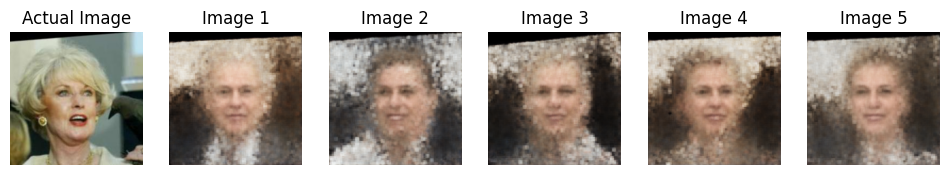

In [12]:
# Set VAE to evaluation mode
model.eval()

# Select a random image from the dataset
with torch.no_grad():
    x,y = next(iter(dataloader))
    random_index = random.randint(0, x.size(0) - 1)
    actual_image = x[random_index].unsqueeze(0).to(device)  # Add batch dimension

    # Encodeing image to get latent space representation
    p = model.encoded_image(actual_image)
    p = p.view(p.size(0), -1)
        
    # Computing mean and log variance vectors
    mu, logvar = model.mu(p), model.logvar(p)
    
    # Reparameterize, to sample from the latent space
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    q = mu + eps * std

    # Ploting original image
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 6, 1)
    plt.imshow(actual_image.cpu().squeeze().permute(1, 2, 0))
    plt.title("Actual Image")
    plt.axis('off')

    # Generating and ploting similar images with amplified variations
    for i in range(2, 7):
        # amplified variation
        q_varied = q + torch.randn_like(z) * 0.5  # Increase the variation factor

        h3 = model.decoder_input(q_varied)
        h3 = h3.view(h3.size(0), 64, 32, 32)
        # Decoding the varied latent vector
        generated_image_varied = model.decoded_image(h3)

        # Plotting
        plt.subplot(2, 6, i)
        plt.imshow(generated_image_varied.cpu().squeeze().permute(1, 2, 0))
        plt.title(f"Image {i-1}")
        plt.axis('off')

    plt.show()